# Decision Trees — Offer Decision Tree Demo

This notebook uses **one consistent case** throughout:

**“Should I accept a new job offer?”** (binary classification: *accept* vs *decline*).

It mirrors the slide flow:
1. CART + Gini
2. ID3 + Entropy / Information Gain
3. Overfitting + Pruning
4. Ensemble methods


In [1]:
# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# scikit-learn (trees + metrics)
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    ConfusionMatrixDisplay,
)

# Ensembles
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)

# Reproducibility
RNG = np.random.default_rng(42)


## 2) CART: impurity measures and split quality

CART chooses the split that **minimises node impurity** (often Gini).

**Gini impurity** for node $t$:
$$
\mathrm{GINI}(t)=1-\sum_{j=1}^{n_c} p(j\mid t)^2.
$$

For binary classes with class-1 proportion $p$:
$$
\mathrm{GINI}(p)=2p(1-p),
$$
maximal at $p=0.5$ and minimal at $p\in\{0,1\}$.


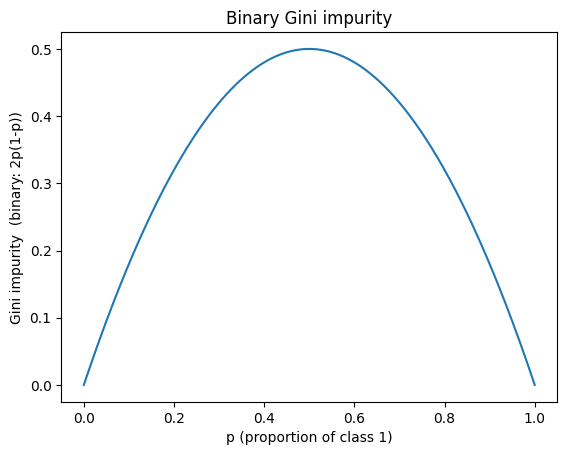

In [2]:
def gini_impurity(y):
    """Gini impurity: 1 - sum_k p_k^2."""
    y = pd.Series(y)
    probs = y.value_counts(normalize=True)
    return 1.0 - np.sum(probs.values ** 2)

def entropy(y):
    """Entropy: -sum_k p_k log2 p_k."""
    y = pd.Series(y)
    probs = y.value_counts(normalize=True).values
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

def weighted_impurity(children, impurity_fn=gini_impurity):
    """Weighted impurity after a split."""
    total = sum(len(c) for c in children)
    return sum((len(c) / total) * impurity_fn(c) for c in children)

def gain(parent, children, impurity_fn=gini_impurity):
    """Impurity reduction."""
    return impurity_fn(parent) - weighted_impurity(children, impurity_fn=impurity_fn)

def plot_binary_gini_curve():
    p = np.linspace(0, 1, 501)
    g = 2 * p * (1 - p)
    plt.figure()
    plt.plot(p, g)
    plt.xlabel("p (proportion of class 1)")
    plt.ylabel("Gini impurity  (binary: 2p(1-p))")
    plt.title("Binary Gini impurity")
    plt.show()

plot_binary_gini_curve()


## 3) Offer decision tree dataset (used throughout)

We encode an offer as features and a label:

- Salary (in £k): `salary_k`
- Commute time (hours): `commute_h`
- Free coffee? (0/1): `free_coffee`
- Label: `accept` (1 = accept, 0 = decline)

Toy “slide-style” rule (for reference):
> Accept **only if** salary ≥ 50k, commute ≤ 1 hour, and free coffee is offered.


In [3]:
def hand_crafted_offer_rule(df):
    """Slide-style offer rule (binary)."""
    return (
        (df["salary_k"] >= 50)
        & (df["commute_h"] <= 1.0)
        & (df["free_coffee"] == 1)
    ).astype(int)

# Small, interpretable dataset (used for the worked CART/ID3 examples).
# We intentionally include several (salary<50, commute<=1) *declines* so that:
#   - split on salary is clearly better than split on commute (for slides 6–9).
offer_small = pd.DataFrame(
    [
        # salary_k, commute_h, free_coffee
        (45, 0.5, 1),
        (48, 1.2, 1),
        (49, 0.8, 0),
        (52, 0.7, 0),
        (55, 0.9, 1),
        (57, 1.3, 1),
        (60, 0.6, 1),
        (62, 0.8, 0),
        (65, 0.9, 1),
        (67, 1.4, 1),
        (70, 0.7, 1),
        (72, 0.9, 0),

        # extra low-salary + good-commute declines (to break the tie between salary and commute)
        (40, 0.6, 1),
        (42, 0.7, 0),
        (46, 0.9, 1),
        (47, 0.8, 1),
    ],
    columns=["salary_k", "commute_h", "free_coffee"],
)

offer_small["accept"] = hand_crafted_offer_rule(offer_small)

offer_small


,salary_k,commute_h,free_coffee,accept
0,45,0.5,1,0
1,48,1.2,1,0
2,49,0.8,0,0
3,52,0.7,0,0
4,55,0.9,1,1
5,57,1.3,1,0
6,60,0.6,1,1
7,62,0.8,0,0
8,65,0.9,1,1
9,67,1.4,1,0


### 3.1 Gini worked example on the offer case

We compare **two candidate split conditions** and compute:

1. Gini for each branch
2. The **weighted split impurity**:
$$
\mathrm{GINI}_{\mathrm{split}}=\sum_{i=1}^{k} \frac{n_i}{n}\,\mathrm{GINI}(i)
$$
3. Choose the split with **smaller** $\mathrm{GINI}_{\mathrm{split}}$ (equivalently, larger gain).


In [4]:
def split_summary(df, target, mask, name_true="True", name_false="False"):
    """Return class counts + gini for a binary split mask."""
    y = df[target]
    y_t = y[mask]
    y_f = y[~mask]

    def counts(yvec):
        vc = yvec.value_counts().reindex([0, 1], fill_value=0)
        return {"decline(0)": int(vc.loc[0]), "accept(1)": int(vc.loc[1])}

    out = {
        "branch": [name_true, name_false],
        "n": [len(y_t), len(y_f)],
        **{k: [counts(y_t)[k], counts(y_f)[k]] for k in ["decline(0)", "accept(1)"]},
        "gini": [gini_impurity(y_t), gini_impurity(y_f)],
    }
    return pd.DataFrame(out), y_t, y_f

y_parent = offer_small["accept"]
print("GINI(parent) =", gini_impurity(y_parent))

# Candidate split A: salary >= 50?
mask_salary = offer_small["salary_k"] >= 50
tab_salary, y_t_salary, y_f_salary = split_summary(
    offer_small, "accept", mask_salary, name_true="salary≥50", name_false="salary<50"
)
gini_split_salary = weighted_impurity([y_t_salary, y_f_salary])
print("\nCandidate split A: salary≥50")
display(tab_salary)
print("GINI_split =", gini_split_salary, "  Gain =", gain(y_parent, [y_t_salary, y_f_salary]))

# Candidate split B: commute <= 1?
mask_commute = offer_small["commute_h"] <= 1.0
tab_commute, y_t_commute, y_f_commute = split_summary(
    offer_small, "accept", mask_commute, name_true="commute≤1h", name_false="commute>1h"
)
gini_split_commute = weighted_impurity([y_t_commute, y_f_commute])
print("\nCandidate split B: commute≤1h")
display(tab_commute)
print("GINI_split =", gini_split_commute, "  Gain =", gain(y_parent, [y_t_commute, y_f_commute]))

print("\nBetter split (smaller GINI_split):",
      "salary≥50" if gini_split_salary < gini_split_commute else "commute≤1h")


GINI(parent) = 0.375

Candidate split A: salary≥50


,branch,n,decline(0),accept(1),gini
0,salary≥50,9,5,4,0.493827
1,salary<50,7,7,0,0.000000


GINI_split = 0.2777777777777778   Gain = 0.09722222222222221

Candidate split B: commute≤1h


,branch,n,decline(0),accept(1),gini
0,commute≤1h,13,9,4,0.426036
1,commute>1h,3,3,0,0.000000


GINI_split = 0.3461538461538462   Gain = 0.0288461538461538

Better split (smaller GINI_split): salary≥50


## 4) CART example: learn the offer decision tree

We fit a CART tree to the **offer** dataset and visualise the learned tree.


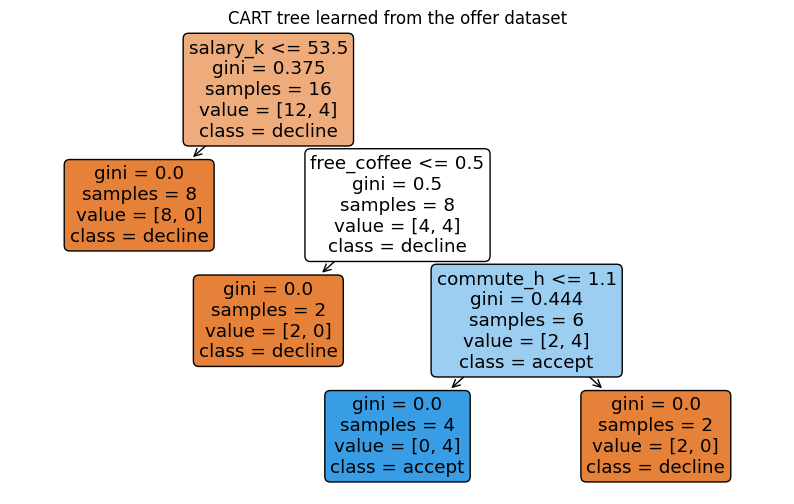

|--- salary_k <= 53.50
|   |--- class: 0
|--- salary_k >  53.50
|   |--- free_coffee <= 0.50
|   |   |--- class: 0
|   |--- free_coffee >  0.50
|   |   |--- commute_h <= 1.10
|   |   |   |--- class: 1
|   |   |--- commute_h >  1.10
|   |   |   |--- class: 0



In [5]:
features = ["salary_k", "commute_h", "free_coffee"]
X = offer_small[features]
y = offer_small["accept"]

tree_small = DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,
    random_state=42,
)
tree_small.fit(X, y)

plt.figure(figsize=(10, 6))
plot_tree(
    tree_small,
    feature_names=features,
    class_names=["decline", "accept"],
    filled=True,
    rounded=True,
    impurity=True,
)
plt.title("CART tree learned from the offer dataset")
plt.show()

print(export_text(tree_small, feature_names=features))


### 4.1 Compare against the slide rule

We compare the learned tree with the hand-crafted rule on the toy dataset.


Accuracy (tree vs labels): 1.0
Accuracy (rule vs labels): 1.0


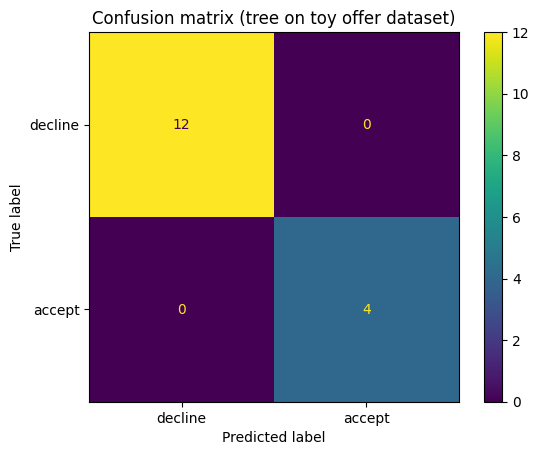

In [6]:
y_rule = hand_crafted_offer_rule(offer_small)
y_pred = tree_small.predict(X)

print("Accuracy (tree vs labels):", accuracy_score(y, y_pred))
print("Accuracy (rule vs labels):", accuracy_score(y, y_rule))

ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels=["decline", "accept"])
plt.title("Confusion matrix (tree on toy offer dataset)")
plt.show()


## 5) ID3: Entropy and Information Gain

Entropy at node $t$:
$$
H(t)=-\sum_{j=1}^{n_c} p(j\mid t)\log_2 p(j\mid t)
$$

Information gain for a split into children $i=1\ldots k$:
$$
\mathrm{GAIN}_{\mathrm{split}} = H(\text{parent}) - \sum_{i=1}^{k} \frac{n_i}{n} H(i).
$$


Entropy(parent) = 0.8112781244591328
Entropy gain (salary≥50)  = 0.2537978408001328
Entropy gain (commute≤1h) = 0.0877536667807961
Better split (higher gain): salary≥50


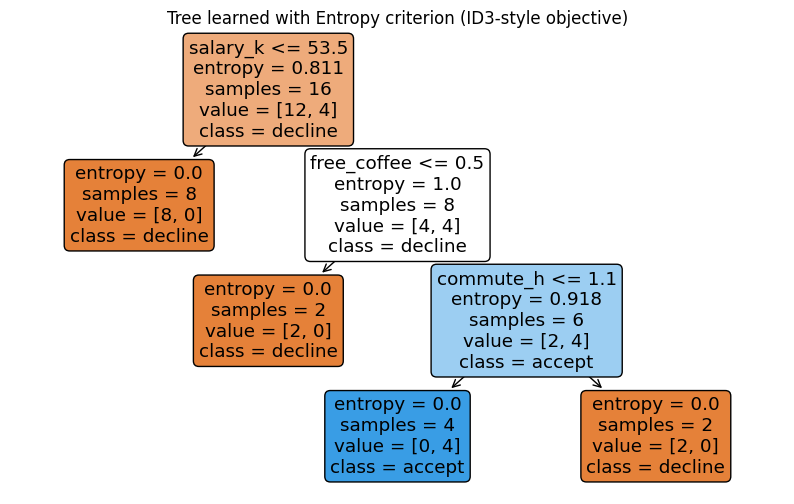

In [7]:
parent_entropy = entropy(y)
print("Entropy(parent) =", parent_entropy)

gain_salary_entropy = gain(y, [y_t_salary, y_f_salary], impurity_fn=entropy)
gain_commute_entropy = gain(y, [y_t_commute, y_f_commute], impurity_fn=entropy)

print("Entropy gain (salary≥50)  =", gain_salary_entropy)
print("Entropy gain (commute≤1h) =", gain_commute_entropy)
print("Better split (higher gain):",
      "salary≥50" if gain_salary_entropy > gain_commute_entropy else "commute≤1h")

tree_small_entropy = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
tree_small_entropy.fit(X, y)

plt.figure(figsize=(10, 6))
plot_tree(
    tree_small_entropy,
    feature_names=features,
    class_names=["decline", "accept"],
    filled=True,
    rounded=True,
    impurity=True,
)
plt.title("Tree learned with Entropy criterion (ID3-style objective)")
plt.show()


## 6) Overfitting in decision trees

We generate a larger **offer-themed** dataset with label noise and irrelevant features, then compare:

- a shallow tree (regularised)
- a deep tree (can overfit)

We also visualise a 2D boundary (salary vs commute) to make overfitting intuitive.


In [8]:
def make_offer_dataset(n=800, noise_rate=0.12, seed=42):
    rng = np.random.default_rng(seed)

    salary_k = rng.uniform(30, 85, size=n)           # £k
    commute_h = rng.uniform(0.0, 2.5, size=n)        # hours
    free_coffee = rng.integers(0, 2, size=n)         # 0/1

    df = pd.DataFrame({
        "salary_k": salary_k,
        "commute_h": commute_h,
        "free_coffee": free_coffee,
        # irrelevant/noisy-but-plausible offer features
        "bonus_k": rng.uniform(0, 15, size=n),
        "team_size": rng.integers(3, 30, size=n),
        "office_plants": rng.integers(0, 25, size=n),
        "snack_score": rng.normal(0, 1, size=n),
    })

    y_true = hand_crafted_offer_rule(df)

    flips = rng.random(n) < noise_rate
    y = y_true.copy()
    y[flips] = 1 - y[flips]
    df["accept"] = y
    return df

offer_big = make_offer_dataset()
offer_big.head()


,salary_k,commute_h,free_coffee,bonus_k,team_size,office_plants,snack_score,accept
0,72.567583,1.846451,1,12.640980,12,13,0.446461,0
1,54.138314,0.792883,1,6.695842,29,19,-0.060092,1
2,77.222886,2.225049,1,14.294627,3,7,0.012579,0
3,68.355242,1.484576,0,9.761919,16,23,0.656819,0
4,35.179754,0.315066,0,1.738483,19,20,-0.727368,0


In [9]:
X = offer_big.drop(columns=["accept"])
y = offer_big["accept"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

tree_shallow = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_deep = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, random_state=42)

tree_shallow.fit(X_train, y_train)
tree_deep.fit(X_train, y_train)

def report(name, model):
    return {
        "model": name,
        "train_acc": accuracy_score(y_train, model.predict(X_train)),
        "test_acc": accuracy_score(y_test, model.predict(X_test)),
        "nodes": model.tree_.node_count,
        "depth": model.get_depth(),
    }

pd.DataFrame([report("shallow (depth=3)", tree_shallow), report("deep (unrestricted)", tree_deep)])


,model,train_acc,test_acc,nodes,depth
0,shallow (depth=3),0.910714,0.858333,15,3
1,deep (unrestricted),1.000000,0.808333,139,16


### 6.1 2D decision boundary (salary vs commute)

To visualise boundaries cleanly, we:
- keep only `salary_k` and `commute_h`
- fix `free_coffee=1` (so acceptance is possible)


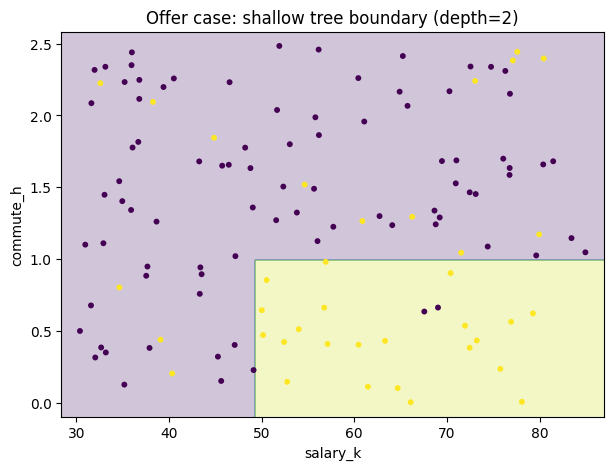

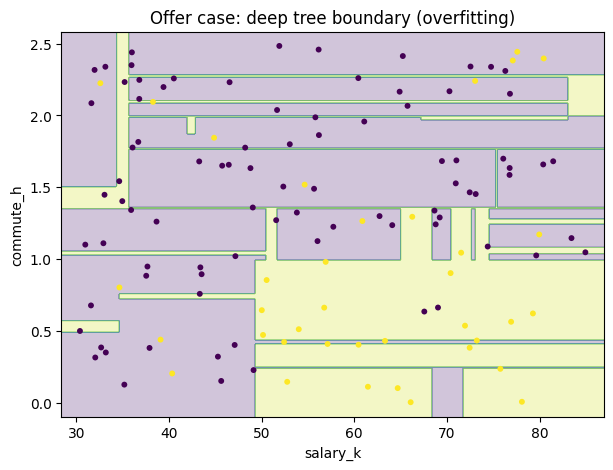

In [10]:
df2 = offer_big[offer_big["free_coffee"] == 1].copy()
df2 = df2.sample(n=min(450, len(df2)), random_state=42)

X2 = df2[["salary_k", "commute_h"]]
y2 = df2["accept"]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.3, random_state=42, stratify=y2
)

t2_shallow = DecisionTreeClassifier(max_depth=2, random_state=42)
t2_deep = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, random_state=42)
t2_shallow.fit(X2_train, y2_train)
t2_deep.fit(X2_train, y2_train)

def plot_boundary(model, X, y, title):
    x_min, x_max = X["salary_k"].min() - 2, X["salary_k"].max() + 2
    y_min, y_max = X["commute_h"].min() - 0.1, X["commute_h"].max() + 0.1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 300),
    )
    grid_df = pd.DataFrame({"salary_k": xx.ravel(), "commute_h": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X["salary_k"], X["commute_h"], c=y, s=18, edgecolors="none")
    plt.xlabel("salary_k")
    plt.ylabel("commute_h")
    plt.title(title)
    plt.show()

plot_boundary(t2_shallow, X2_test, y2_test, "Offer case: shallow tree boundary (depth=2)")
plot_boundary(t2_deep, X2_test, y2_test, "Offer case: deep tree boundary (overfitting)")


## 7) Pruning to control overfitting

We use **cost-complexity pruning** (CART) and pick `ccp_alpha` using a validation set.


In [11]:
# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(X_train, y_train)

path = base_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

records = []
trees = []
for a in ccp_alphas:
    t = DecisionTreeClassifier(random_state=42, ccp_alpha=a)
    t.fit(X_train, y_train)
    trees.append(t)
    records.append({
        "alpha": a,
        "nodes": t.tree_.node_count,
        "depth": t.get_depth(),
        "train_acc": accuracy_score(y_train, t.predict(X_train)),
        "val_acc": accuracy_score(y_val, t.predict(X_val)),
    })

df_prune = pd.DataFrame(records)
df_prune.head()


,alpha,nodes,depth,train_acc,val_acc
0,0.000000,125,12,1.000000,0.80625
1,0.001326,119,12,0.997917,0.80000
2,0.001341,113,12,0.995833,0.80000
3,0.001642,103,12,0.991667,0.80000
4,0.001667,95,12,0.987500,0.80000


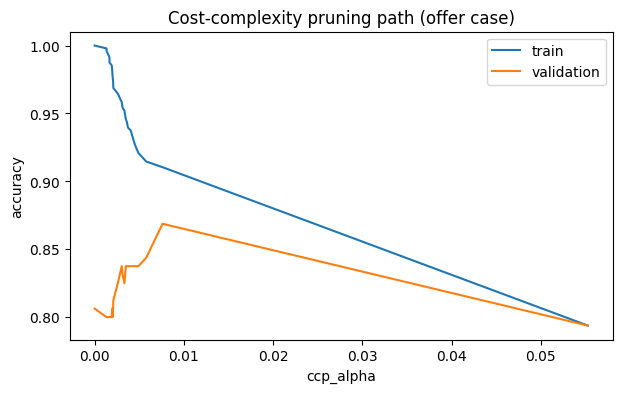

Best alpha (by validation accuracy): 0.007604646697388634
Nodes / depth: 7 / 3
Test accuracy: 0.88125


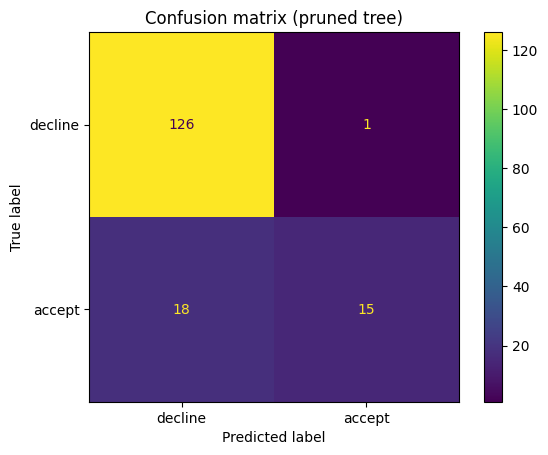

In [12]:
plt.figure(figsize=(7, 4))
plt.plot(df_prune["alpha"], df_prune["train_acc"], label="train")
plt.plot(df_prune["alpha"], df_prune["val_acc"], label="validation")
plt.xlabel("ccp_alpha")
plt.ylabel("accuracy")
plt.title("Cost-complexity pruning path (offer case)")
plt.legend()
plt.show()

best_idx = df_prune["val_acc"].idxmax()
best_alpha = float(df_prune.loc[best_idx, "alpha"])
best_tree = trees[best_idx]

print("Best alpha (by validation accuracy):", best_alpha)
print("Nodes / depth:", best_tree.tree_.node_count, "/", best_tree.get_depth())
print("Test accuracy:", accuracy_score(y_test, best_tree.predict(X_test)))

ConfusionMatrixDisplay.from_predictions(y_test, best_tree.predict(X_test), display_labels=["decline", "accept"])
plt.title("Confusion matrix (pruned tree)")
plt.show()


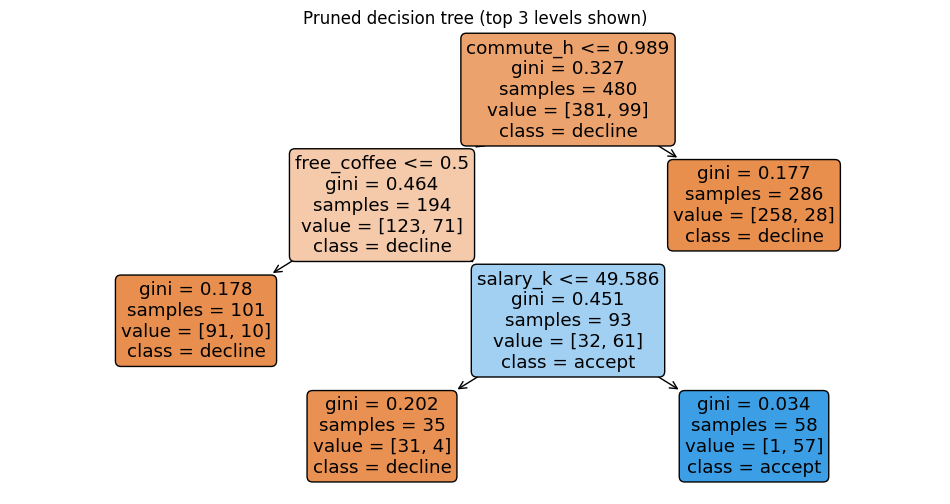

In [13]:
plt.figure(figsize=(12, 6))
plot_tree(
    best_tree,
    feature_names=X.columns.tolist(),
    class_names=["decline", "accept"],
    filled=True,
    rounded=True,
    impurity=True,
    max_depth=3,  # show top levels only
)
plt.title("Pruned decision tree (top 3 levels shown)")
plt.show()


### 7.1 Reduced-error pruning view (validation-based)

A practical way to think about pruning is:

- grow a (potentially) large tree
- try simpler versions
- **keep the change if validation accuracy does not drop**

Our `ccp_alpha` selection above is doing exactly this, by choosing the tree with the best validation accuracy.


In [14]:
# Compare the unpruned tree (alpha=0) vs the chosen pruned tree
unpruned = DecisionTreeClassifier(random_state=42, ccp_alpha=0.0)
unpruned.fit(X_train, y_train)

summary = pd.DataFrame([
    {
        "tree": "unpruned",
        "val_acc": accuracy_score(y_val, unpruned.predict(X_val)),
        "test_acc": accuracy_score(y_test, unpruned.predict(X_test)),
        "nodes": unpruned.tree_.node_count,
        "depth": unpruned.get_depth(),
    },
    {
        "tree": "pruned (best alpha)",
        "val_acc": accuracy_score(y_val, best_tree.predict(X_val)),
        "test_acc": accuracy_score(y_test, best_tree.predict(X_test)),
        "nodes": best_tree.tree_.node_count,
        "depth": best_tree.get_depth(),
    },
])
summary


,tree,val_acc,test_acc,nodes,depth
0,unpruned,0.80625,0.82500,125,12
1,pruned (best alpha),0.86875,0.88125,7,3


### 7.2 Entropy-based pruning (criterion = "entropy")

The same pruning idea applies if the tree is trained with an entropy objective (ID3-style criterion).


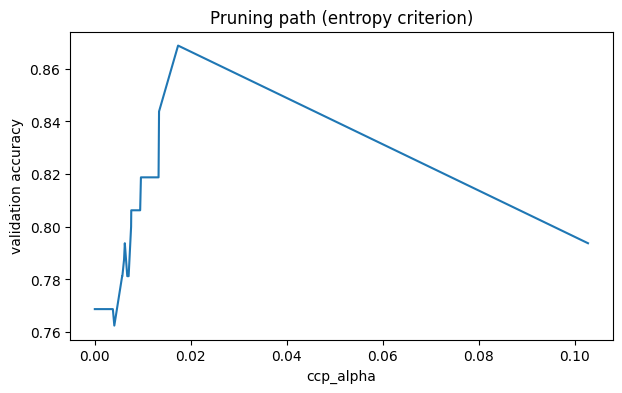

Best entropy-tree alpha: 0.0173465410823054
Test accuracy: 0.88125


In [15]:
entropy_base = DecisionTreeClassifier(random_state=42, criterion="entropy")
entropy_base.fit(X_train, y_train)

epath = entropy_base.cost_complexity_pruning_path(X_train, y_train)
e_alphas = epath.ccp_alphas

e_records = []
e_trees = []
for a in e_alphas:
    t = DecisionTreeClassifier(random_state=42, criterion="entropy", ccp_alpha=a)
    t.fit(X_train, y_train)
    e_trees.append(t)
    e_records.append({
        "alpha": a,
        "nodes": t.tree_.node_count,
        "depth": t.get_depth(),
        "val_acc": accuracy_score(y_val, t.predict(X_val)),
    })

df_eprune = pd.DataFrame(e_records)

plt.figure(figsize=(7, 4))
plt.plot(df_eprune["alpha"], df_eprune["val_acc"])
plt.xlabel("ccp_alpha")
plt.ylabel("validation accuracy")
plt.title("Pruning path (entropy criterion)")
plt.show()

best_e_idx = df_eprune["val_acc"].idxmax()
best_e_tree = e_trees[best_e_idx]
print("Best entropy-tree alpha:", float(df_eprune.loc[best_e_idx, "alpha"]))
print("Test accuracy:", accuracy_score(y_test, best_e_tree.predict(X_test)))


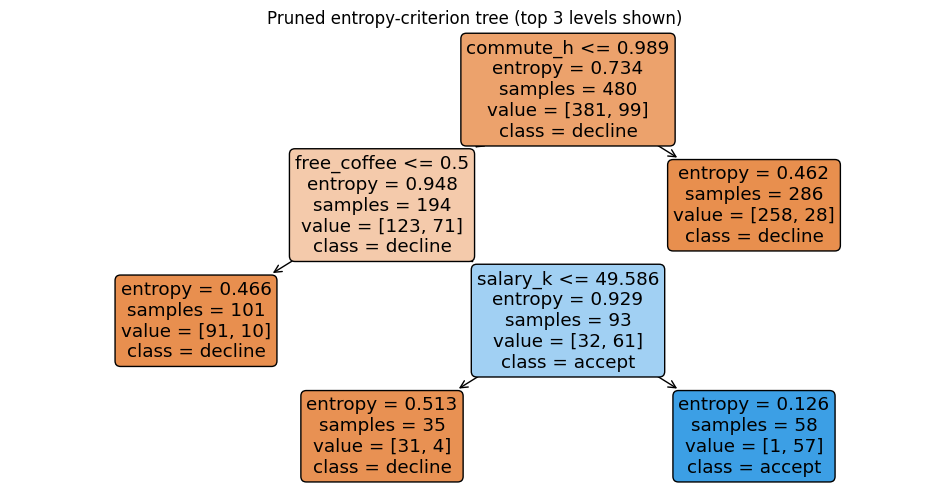

In [16]:
plt.figure(figsize=(12, 6))
plot_tree(
    best_e_tree,
    feature_names=X.columns.tolist(),
    class_names=["decline", "accept"],
    filled=True,
    rounded=True,
    impurity=True,
    max_depth=3,
)
plt.title("Pruned entropy-criterion tree (top 3 levels shown)")
plt.show()


## 8) Ensemble methods with decision trees

We compare a single decision tree with:
- Bagging
- Random Forest
- Boosting (AdaBoost + Gradient Boosting)


In [17]:
# Bootstrap illustration (like slide 21), using 5 'offers'
offers = np.arange(1, 6)
B = 4
boot_samples = [RNG.choice(offers, size=len(offers), replace=True).tolist() for _ in range(B)]

print("Original offers:", offers.tolist())
print("Bootstrap samples:")
for s in boot_samples:
    print(" ", s)


Original offers: [1, 2, 3, 4, 5]
Bootstrap samples:
  [1, 4, 4, 3, 3]
  [5, 1, 4, 2, 1]
  [3, 5, 4, 4, 4]
  [4, 3, 1, 5, 3]


In [18]:
# Train/test split for ensemble comparison
X = offer_big.drop(columns=["accept"])
y = offer_big["accept"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

single_tree = DecisionTreeClassifier(random_state=42)

bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=80,
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
)

rf = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1,
    oob_score=True,
)

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=120,
    learning_rate=0.6,
    random_state=42,
)

gboost = GradientBoostingClassifier(random_state=42)

models = {
    "Single tree": single_tree,
    "Bagging": bagging,
    "Random forest": rf,
    "AdaBoost (stumps)": ada,
    "Gradient boosting": gboost,
}

rows = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rows.append({"model": name, "test_acc": accuracy_score(y_test, y_pred)})

pd.DataFrame(rows).sort_values("test_acc", ascending=False)


,model,test_acc
2,Random forest,0.875000
1,Bagging,0.854167
4,Gradient boosting,0.854167
3,AdaBoost (stumps),0.829167
0,Single tree,0.808333


### 8.1 Bagging: majority vote intuition

Bagging predicts by aggregating many trees (often by **majority vote**).
Below we show vote counts for a few test offers.


In [19]:
# Vote counts from a subset of bagging estimators for a few samples
bag = models["Bagging"]
n_show = 5
n_estimators_show = min(25, len(bag.estimators_))

X_show = X_test.iloc[:n_show]
votes = np.vstack([est.predict(X_show) for est in bag.estimators_[:n_estimators_show]])

vote_counts = pd.DataFrame({
    "decline_votes": (votes == 0).sum(axis=0),
    "accept_votes": (votes == 1).sum(axis=0),
    "majority_pred": (votes.mean(axis=0) >= 0.5).astype(int),
    "true": y_test.iloc[:n_show].to_numpy(),
}, index=X_show.index)

vote_counts


/Users/zhiwu/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/zhiwu/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/zhiwu/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/zhiwu/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/zhiwu/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/zhi

,decline_votes,accept_votes,majority_pred,true
774,22,3,0,0
695,24,1,0,0
337,23,2,0,0
512,25,0,0,0
687,11,14,1,0


### 8.2 Boosting: accuracy as we add more estimators

Boosting adds weak learners sequentially. A common classroom visual is:
**test accuracy vs number of estimators**.


/Users/zhiwu/.pyenv/versions/3.10.10/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


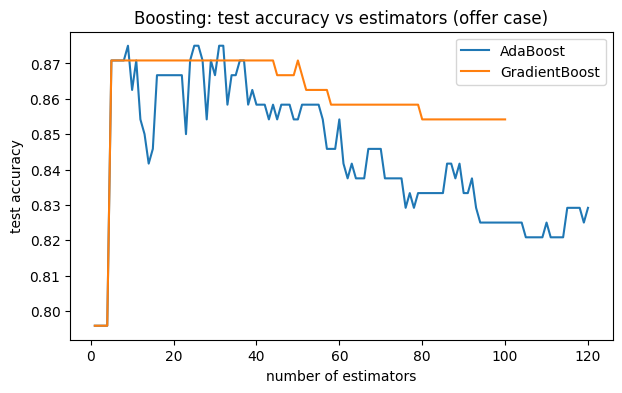

In [20]:
def staged_accuracy(model, X_test, y_test):
    # Works for AdaBoost / GradientBoosting (they provide staged_predict)
    acc=[]
    for yhat in model.staged_predict(X_test):
        acc.append(accuracy_score(y_test, yhat))
    return np.array(acc)

ada_model = models["AdaBoost (stumps)"]
gb_model = models["Gradient boosting"]

acc_ada = staged_accuracy(ada_model, X_test, y_test)
acc_gb = staged_accuracy(gb_model, X_test, y_test)

plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, len(acc_ada)+1), acc_ada, label="AdaBoost")
plt.plot(np.arange(1, len(acc_gb)+1), acc_gb, label="GradientBoost")
plt.xlabel("number of estimators")
plt.ylabel("test accuracy")
plt.title("Boosting: test accuracy vs estimators (offer case)")
plt.legend()
plt.show()


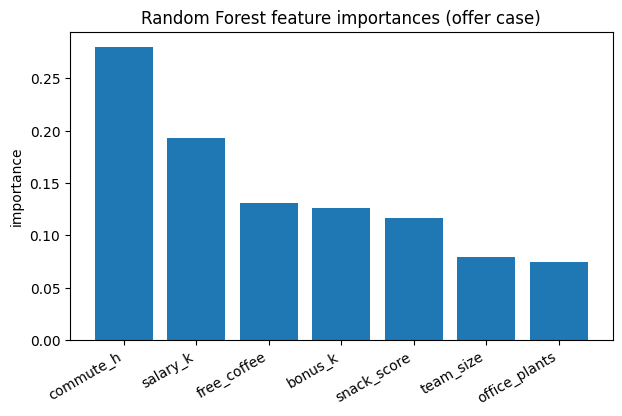

OOB score (RF): 0.8982142857142857


In [21]:
rf_model = models["Random forest"]
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(7, 4))
plt.bar(importances.index[:10], importances.values[:10])
plt.xticks(rotation=30, ha="right")
plt.ylabel("importance")
plt.title("Random Forest feature importances (offer case)")
plt.show()

print("OOB score (RF):", getattr(rf_model, "oob_score_", None))


## 9) Summary (mirrors the slide takeaways)

- **CART** minimises impurity (e.g., Gini) to choose splits.
- **ID3/C4.5** maximise information gain (entropy reduction).
- Trees can **overfit**; pruning reduces complexity.
- **Ensembles** (bagging, random forests, boosting) usually improve generalisation.
